In [1]:
import sys, os
import numpy as np

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, join

import warnings
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning

sys.path.append(os.path.expanduser('~/repos/ReipurthBallyProject/src'))
sys.path.append(os.path.expanduser('~/repos/runawaysearch/src'))
from utils import gaia_from_image, false_image

from gaia_ps1 import gaiadr3toPanStarrs1, gaia_xmatch_panstars


import mastcasjobs
# user = "kevinmcmanus"
# pwd = "THRo*zvPqL7mWCv8"


In [2]:
scr2 = os.environ.get('CASJOBS_USERID')
print(scr2)


kevinmcmanus


In [3]:
#filename =os.path.join(os.path.dirname(os.getcwd()),'data/HH34_ha.fits')
filename =os.path.join(os.path.dirname(os.getcwd()),'data/ZCMa_ha.fits')

hdu = fits.open(filename)[0]

with warnings.catch_warnings():
    # Ignore a warning on using DATE-OBS in place of MJD-OBS
    warnings.filterwarnings('ignore', message="'datfix' made the change",
                            category=FITSFixedWarning)
    wcs = WCS(hdu.header)

 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


### Get GAIA Records Over Image

In [4]:
 #set up gaia query
from gaiastars import gaiastars as gs
gs.gaia_source_constraints= [
    '{schema}.gaia_source.source_id is not NULL']
flux_cols = ['ra',
 'dec',
 'parallax',
 'pmra',
 'pmdec',
 'radial_velocity',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'ruwe']+['phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux']
gs.gaia_column_dict_gaiadr3['gaiadr3.gaia_source']['tblcols'] = flux_cols

gaia_records = gaia_from_image(hdu)
print(f'Query returned {len(gaia_records)} objects')


INFO: Query finished. [astroquery.utils.tap.core]
Query returned 29773 objects


In [5]:
gaia_ps1 = gaia_xmatch_panstars(gaia_records)

INFO: Query finished. [astroquery.utils.tap.core]
Number of source ids: 29773, matches found: 28490
Records in Table: 28413
Rows requested: 28413, valid rows returned: 28413


### Gaia Cross Match Table

In [6]:
gaia_ps1.info()

<Table length=28462>
       name        dtype                   description                     class     n_bad
----------------- ------- --------------------------------------------- ------------ -----
        source_id   int64                 Unique Gaia source identifier MaskedColumn     0
               ra float64                                                     Column     0
              dec float64                                                     Column     0
         parallax float64                                               MaskedColumn  2764
             pmra float64                                               MaskedColumn  2764
            pmdec float64                                               MaskedColumn  2764
  radial_velocity float32                                               MaskedColumn 27846
  phot_g_mean_mag float32                                               MaskedColumn    48
 phot_bp_mean_mag float32                                            

In [7]:
zz="""
gaia_tbl = Table.from_pandas(gaia_records.objs.reset_index())
# get the cross match table from Gaia
xmatch_tbl = gaiadr3toPanStarrs1(gaia_records.source_idlist())
n_src = len(xmatch_tbl)
n_match = n_src - xmatch_tbl['original_ext_source_id'].mask.sum()
print(f'Number of source ids: {n_src}, matches found: {n_match}')

# rename to objID ala Panstarrs
xmatch_tbl.rename_column('original_ext_source_id', 'objID')

#ditch the rows with no  matches
xmatch_tbl = xmatch_tbl[~xmatch_tbl['objID'].mask]
"""

### Fetch PanSTARRS1 Cross Matches

In [8]:
from PanSTARRS import PanSTARRS1 as ps1

In [9]:
zz=""" pstars = ps1(name='from Gaia xmatch')

pstars.from_obj_idlist(xmatch_tbl['objID'] )
pstars.objs.info() """

### Merge the Gaia and PanSTARRS tables

In [10]:
# # put the gaia source_id on the panstars table
# pstars.objs = join(pstars.objs, xmatch_tbl[['source_id','objID']], keys='objID')

# # join gaia and pstars
# gaia_ps1 = join(gaia_tbl, pstars.objs, keys='source_id')

# gaia_ps1.info()

Text(0.5, 0.98, 'Z CMa')

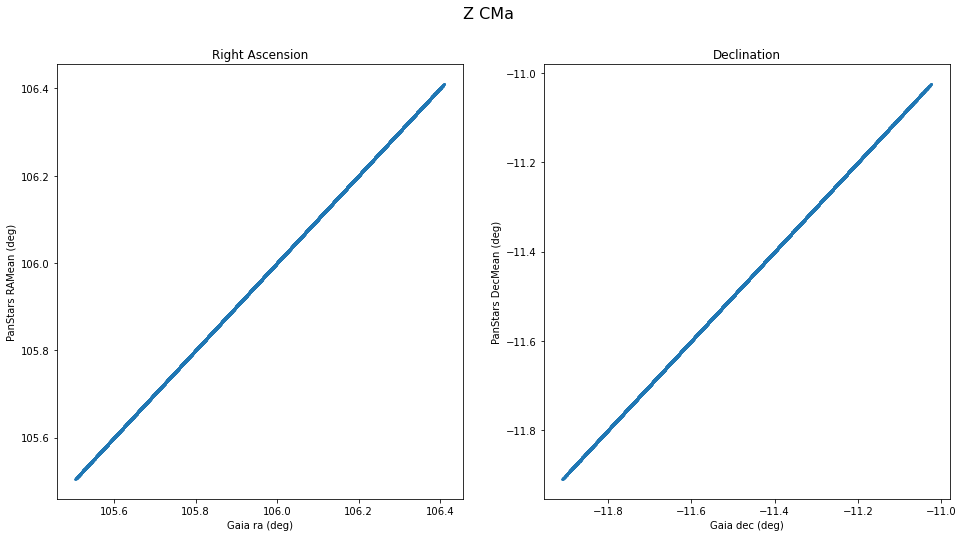

In [11]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(gaia_ps1['ra'], gaia_ps1['RAMean'], s=2)
ax.set_title('Right Ascension')
ax.set_ylabel('PanStars RAMean (deg)')
ax.set_xlabel('Gaia ra (deg)')

ax = fig.add_subplot(122)
ax.scatter(gaia_ps1['dec'], gaia_ps1['DecMean'], s=2)
ax.set_title('Declination')
ax.set_ylabel('PanStars DecMean (deg)')
ax.set_xlabel('Gaia dec (deg)')

fig.suptitle(hdu.header['OBJECT'], size=16)

In [12]:
gaia_ps1['phot_g_mean_mag'].mask.sum(),gaia_ps1['gMeanPSFMag'].mask.sum(),

(48, 3288)

In [13]:
from scipy.stats import linregress

def add_trend_to_scatter(ax, x, y):
    """
    x,y masked arrays
    """
    invalid = np.logical_or(gaia_ps1['phot_g_mean_mag'].mask, gaia_ps1['gMeanPSFMag'].mask)
    xy = np.array([gaia_ps1['phot_g_mean_mag'],gaia_ps1['gMeanPSFMag']])[:,~invalid]

    res = linregress(xy)

    xx = np.linspace(x.min(), x.max(), 10000)

    yhat = res.intercept + res.slope*xx

    ax.plot(xx,yhat, color='red', lw=3, label='Fitted')


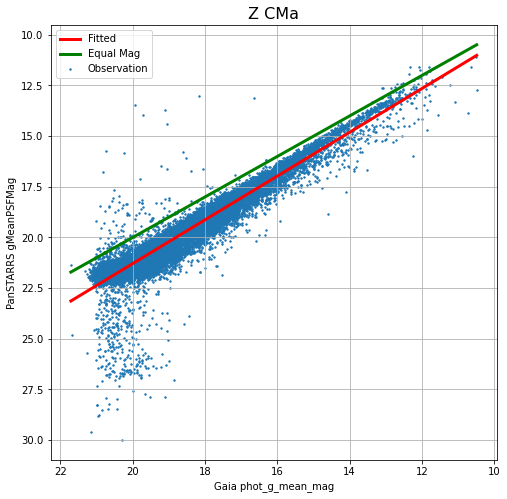

In [14]:
line_equal = np.linspace(gaia_ps1['phot_g_mean_mag'].min(),gaia_ps1['phot_g_mean_mag'].max(), 10000)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(gaia_ps1['phot_g_mean_mag'],gaia_ps1['gMeanPSFMag'],s=2, label='Observation')
add_trend_to_scatter(ax,gaia_ps1['phot_g_mean_mag'],gaia_ps1['gMeanPSFMag'] )

ax.plot(line_equal, line_equal, lw=3, color='green', label='Equal Mag')

ax.set_title(hdu.header['OBJECT'], size=16)
ax.set_xlabel('Gaia phot_g_mean_mag')
ax.set_ylabel('PanSTARRS gMeanPSFMag')
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend()
ax.grid()